Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:

- Download the corpora and split it in training and test sets, structuring a dataframe.
- Embed the words using GloVe embeddings
- Create a baseline model, using a simple neural architecture
- Experiment doing small modifications to the model
- Evaluate your best model
- Analyze the errors of your model
- Corpora: Ignore the numeric value in the third column, use only the words/symbols and its label. https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

Splits: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

Baseline: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.

Modifications: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).

Training and Experiments: all the experiments must involve only the training and validation sets.

Evaluation: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

Error Analysis (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

Report: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

# Sequence labeling

In [704]:
import re
import random
import time
import string
from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchcrf import CRF
from tqdm.notebook import tqdm
from nltk.corpus import dependency_treebank

import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [729]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.xmargin'] = .05
plt.rcParams['axes.ymargin'] = .05
plt.style.use('ggplot')

## Introduction

First of all, let's download the dependency treebank dataset from the NLTK data module$\dots$

In [292]:
dataset_name = "dependency_treebank"

try:
    nltk.data.find(dataset_name)
except LookupError:
    nltk.download(dataset_name)

[nltk_data] Downloading package dependency_treebank to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package dependency_treebank is already up-to-date!


Now we may want to fix all the possible sources of randomness, in order to achieve reproducible results.

In [295]:
RANDOM_SEED = 42


def fix_random(seed):
    """
    Fix all the possible sources of randomness
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


fix_random(RANDOM_SEED)

## Data preparation

In this code section, each and every file in the dependency treebank dataset will be loaded and corresponding sentences will be splitted with the following reasoning:
- Training set range: from file `wsj_0001.dp` to `wsj_0100.dp`
- Validation set range: from file `wsj_0101.dp` to `wsj_0150.dp`
- Test set range: from file `wsj_0151.dp` to `wsj_0199.dp`

In [296]:
file_prefix = "wsj_"
file_ext = ".dp"
train_files = [f"{file_prefix}{i:04d}{file_ext}" for i in range(1, 101)]
val_files = [f"{file_prefix}{i:04d}{file_ext}" for i in range(101, 151)]
test_files = [f"{file_prefix}{i:04d}{file_ext}" for i in range(151, 200)]
splits = (
    ["train"] * len(train_files) + ["val"] * len(val_files) + ["test"] * len(test_files)
)
whole_files = train_files + val_files + test_files

In [297]:
whole_files[0:-1:20]

['wsj_0001.dp',
 'wsj_0021.dp',
 'wsj_0041.dp',
 'wsj_0061.dp',
 'wsj_0081.dp',
 'wsj_0101.dp',
 'wsj_0121.dp',
 'wsj_0141.dp',
 'wsj_0161.dp',
 'wsj_0181.dp']

Let's check how are sentences encoded in each file$\dots$ It seems that they follow the pattern `token \t tag \t number \n`, where `\t` is the tab symbol and `\n` the newline one. 

Since we are only interested in tokens and tags, we can simply discard the last number encountered in the triples in each line of a sentence.

In [298]:
dependency_treebank.raw(fileids=whole_files[0])

'Pierre\tNNP\t2\nVinken\tNNP\t8\n,\t,\t2\n61\tCD\t5\nyears\tNNS\t6\nold\tJJ\t2\n,\t,\t2\nwill\tMD\t0\njoin\tVB\t8\nthe\tDT\t11\nboard\tNN\t9\nas\tIN\t9\na\tDT\t15\nnonexecutive\tJJ\t15\ndirector\tNN\t12\nNov.\tNNP\t9\n29\tCD\t16\n.\t.\t8\n\nMr.\tNNP\t2\nVinken\tNNP\t3\nis\tVBZ\t0\nchairman\tNN\t3\nof\tIN\t4\nElsevier\tNNP\t7\nN.V.\tNNP\t12\n,\t,\t12\nthe\tDT\t12\nDutch\tNNP\t12\npublishing\tVBG\t12\ngroup\tNN\t5\n.\t.\t3\n'

In [299]:
def parse_file(fileid, preprocessor=None):
    """
    Parse the given file identifier from the dependency treebank corpus
    and return a tuple (`tokens`, `tags`), where `tokens` is the list
    of tokens retrieved in the document and `tags` is the associated
    list of tags (`tokens` and `tags` have the same lenght)
    
    If you wish to preprocess tokens, you can pass a function to the
    `preprocessor` argument, which should take as input only the token
    to transform
    """
    file_str = dependency_treebank.raw(fileids=fileid)
    splitted_file_str = [
        x for x in re.split("\t|\n", file_str.strip()) if x.strip() != ""
    ]
    if preprocessor is None:
        preprocessor = lambda t: t
    tokens, tags = [], []
    for i in range(0, len(splitted_file_str), 3):
        token = preprocessor(splitted_file_str[i])
        tag = splitted_file_str[i + 1]
        tokens.append(token)
        tags.append(tag)
    return tokens, tags


def parse_files(fileids, preprocessor=None):
    """
    Parse a set of file identifiers from the dependency treebank corpus
    and return two lists, one which contains lists of tokens and one 
    containing lists of corresponding tags for each file identifier
    """
    tokens_list, tags_list = [], []
    for fileid in fileids:
        tokens, tags = parse_file(fileid, preprocessor=preprocessor)
        tokens_list.append(tokens)
        tags_list.append(tags)
    return tokens_list, tags_list

In [300]:
def preprocess_token(token):
    """
    Peform small modifications to the given token:
        - Transform to lowercase
        - Encode numbers as "<num>"
    """
    token = token.lower()
    token = "<num>" if re.match(utils.FLOAT_RE, token) else token
    return token

In [301]:
whole_tokens, whole_tags = parse_files(whole_files, preprocessor=preprocess_token)

## Data exploration

After extracting the tags and tokens for each sentence of the whole dataset, we may want to observe what their distributions look like (e.g. check the most frequent tags).

In [141]:
def flatten(a):
    """
    Given a 2D list, returns its flattened version
    """
    return [i for s in a for i in s]


flattened_tags = flatten(whole_tags)
flattened_tokens = flatten(whole_tokens)

How many unique tags do we have to deal with?

In [303]:
unique_tags = np.unique(flattened_tags)
print(f"There are {len(unique_tags)} unique tags in the dataset")

There are 45 unique tags in the dataset


What are the 10 most frequent tags?

In [143]:
tags_fd = nltk.probability.FreqDist(flattened_tags)
tags_fd.most_common(10)

[('NN', 13166),
 ('IN', 9857),
 ('NNP', 9410),
 ('DT', 8165),
 ('NNS', 6047),
 ('JJ', 5834),
 (',', 4886),
 ('.', 3874),
 ('CD', 3546),
 ('VBD', 3043)]

What is the distribution of the whole set of tags?

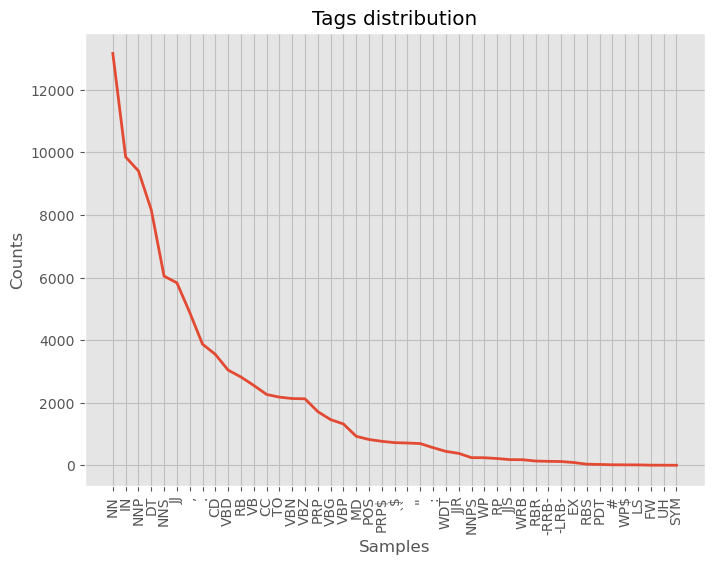

In [701]:
tags_fd.plot(title="Tags distribution", cumulative=False)
plt.show()

How many unique tokens does our dataset have?

In [321]:
unique_tokens = np.unique(flattened_tokens)
print(f"There are {len(unique_tokens)} unique tokens in the dataset")

There are 9964 unique tokens in the dataset


What are the 10 most used tokens?

In [322]:
tokens_fd = nltk.probability.FreqDist(flattened_tokens)
tokens_fd.most_common(10)

[(',', 4885),
 ('the', 4764),
 ('.', 3828),
 ('<num>', 2471),
 ('of', 2325),
 ('to', 2182),
 ('a', 1988),
 ('in', 1769),
 ('and', 1556),
 ("'s", 865)]

What is the distribution of the top 50 tokens with greatest frequency?

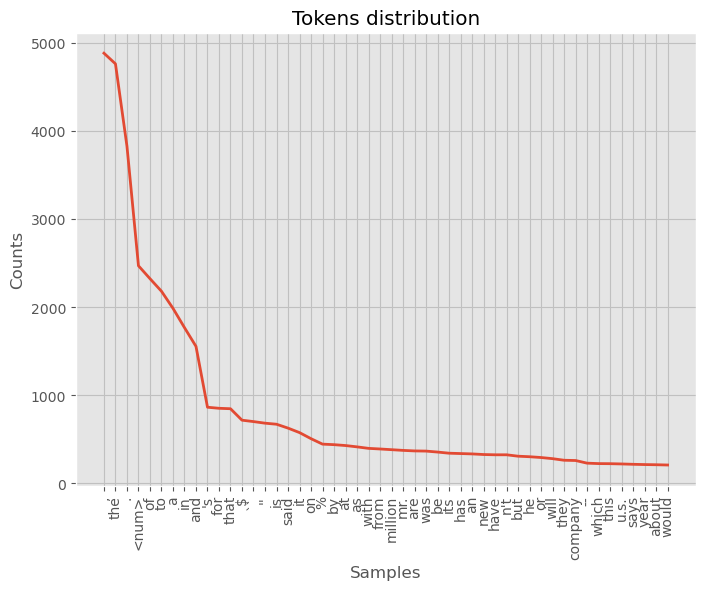

In [702]:
tokens_fd.plot(50, title="Tokens distribution", cumulative=False)
plt.show()

## Vocabulary and DataFrame

The first thing that we have to do is to build two vocabularies, one for tokens and one for tags. The important things about the vocabulary building procedure are mainly two:
1. It must be a deterministic method, i.e. it must output the same result when given the same input
2. The first index of the produced vocabulary (i.e. index zero), must contain the padding token, which will be used at training time to pad sequences in the same batch to be of the same lenght

In [384]:
def build_vocabulary(tokens, padding_token="0"):
    """
    Given a list of tokens, builds the corresponding word vocabulary
    """
    assert padding_token not in tokens
    words = sorted(set(tokens))
    vocabulary, inverse_vocabulary = dict(), dict()
    vocabulary[0] = str(padding_token)
    inverse_vocabulary[str(padding_token)] = 0
    for i, w in tqdm(enumerate(words)):
        vocabulary[i + 1] = w
        inverse_vocabulary[w] = i + 1
    return vocabulary, inverse_vocabulary, [padding_token] + words

Since we want to use the same padding token for both words and tags, we have to check that this token does not appear in our unique lists of tokens and tags$\dots$ 

We will use the padding token `"0"`, since it fulfills both requirements. 

In [385]:
PADDING_TOKEN = "0"
is_token = PADDING_TOKEN in unique_tokens
is_tag = PADDING_TOKEN in unique_tags
print(
    f"Is the padding token in one of the two unique lists of tokens or tags? {is_token or is_tag}"
)

Is the padding token in one of the two unique lists of tokens or tags? False


In [386]:
index_to_word, word_to_index, word_listing = build_vocabulary(
    unique_tokens, padding_token=PADDING_TOKEN
)

9964it [00:00, 651544.91it/s]


In [387]:
list(index_to_word.items())[:10]

[(0, '0'),
 (1, '!'),
 (2, '#'),
 (3, '$'),
 (4, '%'),
 (5, '&'),
 (6, "'"),
 (7, "''"),
 (8, "'30s"),
 (9, "'40s")]

In [388]:
index_to_tag, tag_to_index, tag_listing = build_vocabulary(
    unique_tags, padding_token=PADDING_TOKEN
)

45it [00:00, 207182.96it/s]


In [389]:
list(index_to_tag.items())[:10]

[(0, '0'),
 (1, '#'),
 (2, '$'),
 (3, "''"),
 (4, ','),
 (5, '-LRB-'),
 (6, '-RRB-'),
 (7, '.'),
 (8, ':'),
 (9, 'CC')]

We will also store a subset of tokens that will be used to compute evaluation metrics, such as the F1 score, on a restricted number of labels. In particular, we want to compute those metrics without considering the labels for punctuation tags.

In [392]:
no_punct_tags = [PADDING_TOKEN] + list(set(tag_listing) - set(string.punctuation))
no_punct_tags_indexes = [tag_to_index[t] for t in no_punct_tags]
print(no_punct_tags)

['0', 'DT', 'NNPS', 'WDT', 'IN', 'JJR', 'NN', 'PRP', 'VBD', 'WP$', 'LS', 'MD', 'NNS', 'VB', '``', 'RB', 'RP', 'RBS', 'CC', 'WP', 'VBG', 'CD', 'POS', 'FW', 'VBP', 'NNP', '0', 'UH', 'VBZ', 'JJS', 'PRP$', '-LRB-', '-RRB-', 'JJ', 'SYM', 'EX', "''", 'RBR', 'WRB', 'PDT', 'VBN', 'TO']


In [393]:
def to_indexes(values, to_index):
    """
    Given a list of keys and a dictionary indexed by those keys,
    return the corresponding values in the dictionary
    """
    return [to_index[v] for v in values]


whole_indexed_tokens = map(
    lambda tokens: to_indexes(tokens, word_to_index), whole_tokens
)
whole_indexed_tags = map(lambda tags: to_indexes(tags, tag_to_index), whole_tags)

Finally, we can build the entire DataFrame, by inserting the following columns:
- `tokens`: the list of tokens in a sentence
- `indexed_tokens`: the list of indexes of each word in the sentence, taken from the previously built words vocabulary
- `tags`: the list of tags associated to each token in a sentence
- `indexed_tags`: the list of indexes of each tag in the sentence, taken from the previously built tags vocabulary
- `split`: the split (`train`, `val` or `test`) associated to a particular example
- `fileid`: the file identifier associated to each sentence

In [394]:
df = pd.DataFrame(
    {
        "tokens": whole_tokens,
        "indexed_tokens": whole_indexed_tokens,
        "tags": whole_tags,
        "indexed_tags": whole_indexed_tags,
        "split": splits,
        "fileid": whole_files,
    }
)
df.head()

,tokens,indexed_tokens,tags,indexed_tags,split,fileid
0,"[pierre, vinken, ,, <num>, years, old, ,, will...","[6562, 9557, 20, 40, 9919, 6130, 20, 9793, 474...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...","[21, 21, 4, 10, 23, 15, 4, 19, 35, 11, 20, 14,...",train,wsj_0001.dp
1,"[rudolph, agnew, ,, <num>, years, old, and, fo...","[7695, 256, 20, 40, 9919, 6130, 394, 3607, 146...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...","[21, 21, 4, 10, 23, 15, 9, 15, 20, 14, 21, 21,...",train,wsj_0002.dp
2,"[a, form, of, asbestos, once, used, to, make, ...","[45, 3601, 6095, 570, 6146, 9453, 9063, 5302, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...","[11, 20, 14, 20, 28, 38, 33, 35, 21, 20, 23, 4...",train,wsj_0003.dp
3,"[yields, on, money-market, mutual, funds, cont...","[9931, 6144, 5688, 5792, 3725, 1968, 9063, 821...","[NNS, IN, JJ, JJ, NNS, VBD, TO, VB, ,, IN, NNS...","[23, 14, 15, 15, 23, 36, 33, 35, 4, 14, 23, 14...",train,wsj_0004.dp
4,"[j.p., bolduc, ,, vice, chairman, of, w.r., gr...","[4701, 1024, 20, 9535, 1462, 6095, 9609, 3894,...","[NNP, NNP, ,, NN, NN, IN, NNP, NNP, CC, NNP, ,...","[21, 21, 4, 20, 20, 14, 21, 21, 9, 21, 4, 41, ...",train,wsj_0005.dp


## Dataset and DataLoader

In order to correctly work with batches and sequences of different lenght inside of each batch, we need to exploit the objects made available by PyTorch. In particular, we need to wrap our `DataFrame` inside a custom `Dataset` subclass, which will be used later as an input for a `DataLoader` object, that will automatically handle the generation of batches from our examples. 

In [395]:
class DependencyTreebankDataset(Dataset):
    """
    Dependency treebank dataset for POS tagging
    """

    def __init__(self, df):
        self.df = df.copy()
        self.df = self.df.reset_index(drop=True)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        assert isinstance(index, int)
        tokens = self.df.loc[index, "indexed_tokens"]
        tags = self.df.loc[index, "indexed_tags"]
        return tokens, tags

We will build and store three different `Dataset` objects, based on the split parameter of the previously built DataFrame, which will be used in different stages of the learning process, i.e. training, validation and testing.

In [396]:
train_dataset = DependencyTreebankDataset(df[df["split"] == "train"])
val_dataset = DependencyTreebankDataset(df[df["split"] == "val"])
test_dataset = DependencyTreebankDataset(df[df["split"] == "test"])

Let's see if our `Dataset` building process worked out nicely, by checking the first example in the training dataset$\dots$

In [397]:
print(train_dataset[0])

([6562, 9557, 20, 40, 9919, 6130, 20, 9793, 4749, 8966, 1013, 568, 45, 5988, 2554, 6028, 40, 27, 5755, 9557, 4676, 1462, 6095, 2953, 5808, 20, 8966, 2826, 7018, 3943, 27], [21, 21, 4, 10, 23, 15, 4, 19, 35, 11, 20, 14, 11, 15, 20, 21, 10, 7, 21, 21, 40, 20, 14, 21, 21, 4, 11, 21, 37, 20, 7])


As already mentioned, the `DataLoader` object will be used to automatically handle the generation of batches (with the specified batch size) from the entire list of examples$\dots$ 

Another important aspect of `DataLoader`s is that they enable us to pad sequences in the same batch to be of the same lenght (i.e. the lenght of the longest sequence in the batch), by using the previously defined padding token. To do so, we leverage PyTorch's `pad_sequence` function.

In [533]:
def pad_batch(batch, padding_token="0"):
    """
    This function expects to receive a list of tuples (i.e. a batch),
    s.t. each tuple contains tokens and tags for one sentence in the batch
    and returns the same sequences padded with the padding token
    """
    (tokens, tags) = zip(*batch)
    tokens_lenghts = [len(x) for x in tokens]
    tags_lenghts = [len(y) for y in tags]
    padded_tokens = pad_sequence(
        [torch.tensor(t) for t in tokens],
        batch_first=True,
        padding_value=int(padding_token),
    )
    padded_tags = pad_sequence(
        [torch.tensor(t) for t in tags],
        batch_first=True,
        padding_value=int(padding_token),
    )
    return padded_tokens, padded_tags, tokens_lenghts, tags_lenghts

In [534]:
batch_size = 5
default_dataloader = partial(
    DataLoader,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=partial(pad_batch, padding_token=PADDING_TOKEN),
    pin_memory=True,
)

As we did with the `Dataset` wrapper, we will store three different `DataLoader` objects, one for each learning stage.

In [535]:
train_dataloader = default_dataloader(train_dataset)
val_dataloader = default_dataloader(val_dataset)
test_dataloader = default_dataloader(test_dataset)

## Building word embeddings

The way we represent words in sequence labeling models is still using word embeddings, exploiting methods like `Word2vec` or `GloVe`. In this whole notebook, we will leverage `GloVe` pre-trained embeddings with a fixed dimensionality (e.g. `50`), as given by the `Gensim` library. 

Because of this, we need to build our embedding matrix, i.e. a matrix $E$ of size $w\times d$, where $w$ is the number of unique words in our dataset and $d$ is the dimensionality of word embeddings (in our example $d=50$). In order to correctly build the embedding matrix, we need a way to handle OOV (Out Of Vocabulary) words, i.e. words that appear in our dataset but not on the dataset on which the embeddings where trained on. We will try different OOV handling methods:
- `uniform`: the OOV word vector is sampled from a uniform distribution in a specific range (e.g. $[-1,1]$)
- `normal`: the OOV word vector is sampled from a normal distribution (i.e. a Gaussian with $\mu=0$ and $\sigma=1$)
- `mean`: the OOV word vector is taken as the average of the not OOV word vectors represented by neighbors of the analyzed word (considering a window size of $1$)
- `subword`: the OOV word vector is estimated by a recurrent model, using subword information (i.e. using characters as inputs instead of words)

Moreover, we also zero-out the word vector associated with the padding token.

In [598]:
embedding_dimension = 300
embedding_model = utils.load_embedding_model(
    "glove", embedding_dimension=embedding_dimension
)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [599]:
def check_oov_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms
    """
    oov_terms = []
    for word in word_listing:
        if word not in embedding_model.vocab:
            oov_terms.append(word)
    return oov_terms

In [600]:
oov_terms = check_oov_terms(embedding_model, word_listing)
print(
    f"Total OOV terms: {len(oov_terms)} ({round(len(oov_terms) / len(word_listing), 2)}%)"
)

Total OOV terms: 508 (0.05%)


In [601]:
def build_embedding_matrix(
    embedding_model,
    embedding_dimension,
    word_to_index,
    oov_terms,
    method="normal",
    padding_token="0",
):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained Gensim word embedding model
    """

    def uniform_embedding(embedding_dimension, interval=(-1, 1)):
        return interval[0] + np.random.sample(embedding_dimension) + interval[1]

    def normal_embedding(embedding_dimension):
        return np.random.normal(embedding_dimension)

    embedding_matrix = np.zeros((len(word_to_index), embedding_dimension))
    for word, index in word_to_index.items():
        if word == padding_token:
            word_vector = np.zeros((1, embedding_dimension))
        # Words that are no OOV are taken from the Gensim model
        elif word not in oov_terms:
            word_vector = embedding_model[word]
        # OOV words computed as random normal vectors
        elif method == "normal":
            word_vector = normal_embedding(embedding_dimension)
        # OOV words computed as uniform vectors in range [-1, 1]
        elif method == "uniform":
            word_vector = uniform_embedding(embedding_dimension)
        embedding_matrix[index, :] = word_vector
    return embedding_matrix

Let's build the embedding matrix using the `normal` method for OOV words and check the embedding of a common word like `"the"`$\dots$

In [602]:
embedding_matrix = build_embedding_matrix(
    embedding_model,
    embedding_dimension,
    word_to_index,
    oov_terms,
    method="normal",
    padding_token=PADDING_TOKEN,
)
embedding_matrix[word_to_index["the"]]

array([ 4.65600006e-02,  2.13180006e-01, -7.43639981e-03, -4.58539993e-01,
       -3.56389992e-02,  2.36430004e-01, -2.88360000e-01,  2.15210006e-01,
       -1.34859994e-01, -1.64129996e+00, -2.60910004e-01,  3.24340016e-02,
        5.66210002e-02, -4.32960019e-02, -2.16719992e-02,  2.24759996e-01,
       -7.51290023e-02, -6.70180023e-02, -1.42470002e-01,  3.88250016e-02,
       -1.89510003e-01,  2.99769998e-01,  3.93049985e-01,  1.78870007e-01,
       -1.73429996e-01, -2.11779997e-01,  2.36169994e-01, -6.36809990e-02,
       -4.23180014e-01, -1.16609998e-01,  9.37540010e-02,  1.72959998e-01,
       -3.30729991e-01,  4.91120011e-01, -6.89949989e-01, -9.24620032e-02,
        2.47419998e-01, -1.79910004e-01,  9.79079977e-02,  8.31179991e-02,
        1.52989998e-01, -2.72760004e-01, -3.89339998e-02,  5.44529974e-01,
        5.37370026e-01,  2.91049987e-01, -7.35139987e-03,  4.78800014e-02,
       -4.07599986e-01, -2.67590005e-02,  1.79189995e-01,  1.09770000e-02,
       -1.09630004e-01, -

Let's also check the embedding of the padding token, which should contain all zero entries$\dots$

In [603]:
embedding_matrix[word_to_index[PADDING_TOKEN]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Learning utils

In [607]:
def categorical_accuracy(predictions, ground_truth, padding_index=0, batch_first=True):
    """
    Returns accuracy score over the given batch of data
    """
    if batch_first:
        predictions = predictions.view(-1, predictions.shape[-1])
        ground_truth = ground_truth.view(-1)
    max_predictions = predictions.argmax(dim=1, keepdim=True)
    non_pad_elements = torch.where(ground_truth != padding_index)[0]
    correct = (
        max_predictions[non_pad_elements].squeeze(1).eq(ground_truth[non_pad_elements])
    )
    return correct.sum() / torch.FloatTensor([ground_truth[non_pad_elements].shape[0]])

In [730]:
def f1_score(predictions, ground_truth, labels=None, padding_index=0, batch_first=True):
    """
    Returns F1-macro score over the given batch of data
    """
    if batch_first:
        predictions = predictions.view(-1, predictions.shape[-1])
        ground_truth = ground_truth.view(-1)
    max_predictions = predictions.argmax(dim=1)
    non_pad_elements = torch.where(ground_truth != padding_index)[0]
    return sklearn.metrics.f1_score(
        ground_truth[non_pad_elements].cpu().detach().tolist(),
        max_predictions[non_pad_elements].cpu().detach().tolist(),
        labels=labels,
        average="macro",
    )

In [739]:
def train(model, dataloader):
    """
    Train the given model with the given dataloader
    """
    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    model.train()
    dataloader_progress = tqdm(enumerate(dataloader))
    for i, batch in dataloader_progress:
        model.optimizer.zero_grad()
        tokens, tags, tokens_lenghts, tags_lenghts = batch
        predictions = model(tokens, tokens_lenghts)
        loss = model.loss(predictions, tags)
        acc = categorical_accuracy(predictions, tags)
        f1 = f1_score(predictions, tags, labels=no_punct_tags_indexes)
        loss.backward()
        model.optimizer.step()
        epoch_loss = epoch_loss + ((loss.item() - epoch_loss) / (i + 1))
        epoch_acc = epoch_acc + ((acc.item() - epoch_acc) / (i + 1))
        epoch_f1 = epoch_f1 + ((f1.item() - epoch_f1) / (i + 1))
        dataloader_progress.set_postfix({"epoch_train_f1": f"{epoch_f1 * 100:.2f}"})

    return epoch_loss, epoch_acc, epoch_f1

In [740]:
def evaluate(model, dataloader):
    """
    Evaluate the given model with the given dataloader
    """
    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    model.eval()
    with torch.no_grad():
        dataloader_progress = tqdm(enumerate(dataloader))
        for i, batch in dataloader_progress:
            tokens, tags, tokens_lenghts, tags_lenghts = batch
            predictions = model(tokens, tokens_lenghts)
            loss = model.loss(predictions, tags)
            acc = categorical_accuracy(predictions, tags)
            f1 = f1_score(predictions, tags, no_punct_tags_indexes)
            epoch_loss = epoch_loss + ((loss.item() - epoch_loss) / (i + 1))
            epoch_acc = epoch_acc + ((acc.item() - epoch_acc) / (i + 1))
            epoch_f1 = epoch_f1 + ((f1.item() - epoch_f1) / (i + 1))
            dataloader_progress.set_postfix({"epoch_val_f1": f"{epoch_f1 * 100:.2f}"})

    return epoch_loss, epoch_acc, epoch_f1

In [741]:
def train_val_test(
    model, model_name, train_dataloader, val_dataloader, test_dataloader, epochs=10
):
    """
    Perform training, validation and testing on the given model,
    for the specified number of epochs
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }
    best_val_loss = float("inf")
    epoch_progress = tqdm(range(epochs))
    for epoch in epoch_progress:
        # Perform training
        train_loss, train_acc, train_f1 = train(model, train_dataloader)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)

        # Perform evaluation
        val_loss, val_acc, val_f1 = evaluate(model, val_dataloader)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # Update progress bar
        epoch_progress.set_postfix({"val_acc": f"{val_acc * 100:.2f}"})

        # Save the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"models/{model_name}.pt")

    # Test the model
    model.load_state_dict(torch.load(f"models/{model_name}.pt"))
    test_loss, test_acc, test_f1 = evaluate(model, test_dataloader)
    print(
        f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc * 100:.2f}% | Test F1: {test_f1 * 100:.2f}%"
    )

    return history

In [742]:
def plot_history(history, nrows=2, ncols=3):
    """
    Given an history dictionary (as built in the `train_val_test` function),
    plots the whole training information
    """
    assert nrows * ncols == len(history)
    fig, axes = plt.subplots(nrows, ncols)
    grid = np.arange(len(history)).reshape(nrows, ncols)
    for v, k in enumerate(history):
        i, j = np.argwhere(grid == v).reshape(-1)
        axes[i, j].plot(history[k])
        axes[i, j].legend([k])
    plt.tight_layout()
    plt.show()

## Model definition

In [687]:
class POSTaggingModel(nn.Module):
    def __init__(
        self,
        input_dimension,
        embedding_dimension,
        hidden_dimension,
        output_dimension,
        embedding_matrix=None,
        retrain_embeddings=True,
        gru=True,
        num_layers=1,
        bidirectional=True,
        dropout_rate=0.0,
        lr=1e-3,
        padding_index=0,
        crf=False,
    ):
        """
        Build a generic POS tagging model, with recurrent modules
        """
        super().__init__()
        
        # Padding
        self.padding_index = padding_index
        
        # Get device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Embedding module
        self.embedding = nn.Embedding(
            input_dimension, embedding_dimension, padding_idx=self.padding_index
        )
        if embedding_matrix is not None:
            assert (
                embedding_matrix.shape[0] == input_dimension
                and embedding_matrix.shape[1] == embedding_dimension
            )
            self.embedding.weight = nn.Parameter(torch.FloatTensor(embedding_matrix))
        self.embedding.weight.requires_grad = retrain_embeddings

        # Recurrent module
        recurrent_module = nn.GRU if gru else nn.LSTM
        self.recurrent_module = recurrent_module(
            embedding_dimension,
            hidden_dimension,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate if num_layers > 1 else 0,
        )

        # Dense and dropout layers
        self.dense = nn.Linear(
            hidden_dimension * 2 if bidirectional else hidden_dimension,
            output_dimension,
        )
        self.dropout = nn.Dropout(dropout_rate)

        # Criterion
        self.crf = crf
        self.criterion = (
            nn.CrossEntropyLoss(ignore_index=padding_index).to(self.device)
            if not self.crf
            else CRF(output_dimension, batch_first=True)
        )

        # Optimizer
        self.lr = lr
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        # Transfer model to device
        self.to(self.device)

    def forward(self, tokens, tokens_lenghts):
        embedded = self.dropout(self.embedding(tokens))
        packed = pack_padded_sequence(
            embedded, tokens_lenghts, batch_first=True, enforce_sorted=False
        )
        packed_outputs, (hidden, cell) = self.recurrent_module(packed)
        padded_outputs, outputs_lengths = pad_packed_sequence(
            packed_outputs, batch_first=True
        )
        predictions = self.dense(self.dropout(padded_outputs))
        return predictions

    def loss(self, predictions, tags):
        if not self.crf:
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            return self.criterion(predictions, tags)
        
        mask = torch.zeros(tags.shape, dtype=torch.uint8)
        mask[mask == self.padding_index] = 0
        return -self.criterion(predictions, tags, mask=mask)

In [688]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [689]:
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.1)

In [744]:
hidden_dimension = 128
num_epochs = 30

## Baseline model (BiLSTM + FC)

In [691]:
bilstm_fc_model = POSTaggingModel(
    len(word_to_index),
    embedding_dimension,
    hidden_dimension,
    len(tag_to_index),
    embedding_matrix=embedding_matrix,
    retrain_embeddings=False,
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    padding_index=tag_to_index[PADDING_TOKEN],
    crf=False,
)

In [692]:
print(f"The model has {count_parameters(bilstm_fc_model):,} trainable parameters")

The model has 452,142 trainable parameters


In [693]:
bilstm_fc_model.apply(init_weights)

POSTaggingModel(
  (embedding): Embedding(9965, 300, padding_idx=0)
  (recurrent_module): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=256, out_features=46, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (criterion): CrossEntropyLoss()
)

In [743]:
bilstm_fc_model_history = train_val_test(
    bilstm_fc_model,
    "bilstm_fc_model",
    train_dataloader,
    val_dataloader,
    test_dataloader,
    epochs=num_epochs,
)

KeyboardInterrupt: 

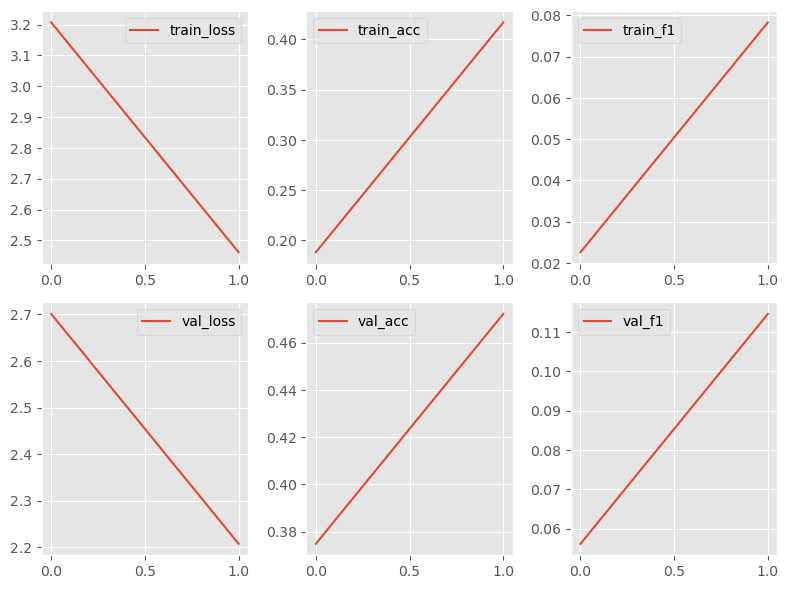

In [728]:
plot_history(bilstm_fc_model_history, nrows=2, ncols=3)

## BiGRU + FC

In [445]:
bigru_fc_model = POSTaggingModel(
    len(word_to_index),
    embedding_dimension,
    hidden_dimension,
    len(tag_to_index),
    embedding_matrix=embedding_matrix,
    retrain_embeddings=False,
    gru=True,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    padding_token=PADDING_TOKEN,
    padding_index=tags_to_index[PADDING_TOKEN],
    crf=False
)

In [446]:
print(f"The model has {count_parameters(bigru_fc_model):,} trainable parameters")

The model has 150,062 trainable parameters


In [447]:
bigru_fc_model.apply(init_weights)

POSTaggingModel(
  (embedding): Embedding(9965, 50, padding_idx=0)
  (recurrent_module): GRU(50, 128, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=256, out_features=46, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (criterion): CrossEntropyLoss()
)

In [454]:
bigru_fc_model_history = train_val_test(
    bigru_fc_model,
    "bigru_fc_model",
    train_dataloader,
    val_dataloader,
    test_dataloader,
    epochs=num_epochs,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 88.30042099952698s
Train loss: 3.349 | Train accuracy: 12.84% | Train F1: 1.42%
Validation loss: 2.953 | Validation accuracy: 14.02% | Validation F1: 1.48%
Saving new checkpoint...

Epoch: 02
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 79.6214325428009s
Train loss: 2.848 | Train accuracy: 21.27% | Train F1: 3.18%
Validation loss: 2.770 | Validation accuracy: 29.21% | Validation F1: 4.27%
Saving new checkpoint...

Epoch: 03
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 78.7057318687439s
Train loss: 2.648 | Train accuracy: 32.41% | Train F1: 5.67%
Validation loss: 2.535 | Validation accuracy: 39.08% | Validation F1: 8.70%
Saving new checkpoint...

Epoch: 04
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 79.58505821228027s
Train loss: 2.401 | Train accuracy: 42.59% | Train F1: 9.56%
Validation loss: 2.276 | Validation accuracy: 44.87% | Validation F1: 10.92%
Saving new checkpoint...

Epoch: 05
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 79.17587208747864s
Train loss: 2.153 | Train accuracy: 45.70% | Train F1: 11.68%
Validation loss: 2.053 | Validation accuracy: 46.25% | Validation F1: 12.36%
Saving new checkpoint...

Epoch: 06
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 77.77035212516785s
Train loss: 1.950 | Train accuracy: 47.68% | Train F1: 13.93%
Validation loss: 1.887 | Validation accuracy: 48.94% | Validation F1: 15.72%
Saving new checkpoint...

Epoch: 07
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 77.77018451690674s
Train loss: 1.798 | Train accuracy: 51.01% | Train F1: 18.31%
Validation loss: 1.761 | Validation accuracy: 52.64% | Validation F1: 21.40%
Saving new checkpoint...

Epoch: 08
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 78.4188117980957s
Train loss: 1.682 | Train accuracy: 53.86% | Train F1: 22.77%
Validation loss: 1.669 | Validation accuracy: 54.24% | Validation F1: 23.77%
Saving new checkpoint...

Epoch: 09
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 78.72956728935242s
Train loss: 1.594 | Train accuracy: 55.42% | Train F1: 24.91%
Validation loss: 1.601 | Validation accuracy: 55.34% | Validation F1: 25.26%
Saving new checkpoint...

Epoch: 10
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

Epoch Time: 79.40816378593445s
Train loss: 1.525 | Train accuracy: 56.81% | Train F1: 26.50%
Validation loss: 1.548 | Validation accuracy: 56.21% | Validation F1: 26.84%
Saving new checkpoint...

Testing...


TypeError: evaluate() takes 2 positional arguments but 3 were given

In [ ]:
plot_history(bigru_fc_model_history, nrows=2, ncols=3)

## BiLSTMx2 + FC

In [ ]:
bilstmx2_fc_model = POSTaggingModel(
    len(word_to_index),
    embedding_dimension,
    hidden_dimension,
    len(tag_to_index),
    embedding_matrix=embedding_matrix,
    retrain_embeddings=False,
    gru=False,
    num_layers=2,
    bidirectional=True,
    dropout_rate=0.0,
    padding_token=PADDING_TOKEN,
    padding_index=tags_to_index[PADDING_TOKEN],
    crf=False
)

In [ ]:
print(f"The model has {count_parameters(bilstmx2_fc_model):,} trainable parameters")

In [ ]:
bilstmx2_fc_model.apply(init_weights)

In [ ]:
bilstmx2_fc_model_history = train_val_test(
    bilstmx2_fc_model,
    "bigru_fc_model",
    train_dataloader,
    val_dataloader,
    test_dataloader,
    epochs=num_epochs,
)

In [ ]:
plot_history(bilstmx2_fc_model_history, nrows=2, ncols=3)

## BiLSTM + FC + CRF

In [590]:
bilstm_fc_crf_model = POSTaggingModel(
    len(word_to_index),
    embedding_dimension,
    hidden_dimension,
    len(tag_to_index),
    embedding_matrix=embedding_matrix,
    retrain_embeddings=False,
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    padding_token=PADDING_TOKEN,
    padding_index=tags_to_index[PADDING_TOKEN],
    crf=True
)

In [591]:
print(f"The model has {count_parameters(bilstm_fc_crf_model):,} trainable parameters")

The model has 198,350 trainable parameters


In [592]:
bilstm_fc_crf_model.apply(init_weights)

POSTaggingModel(
  (embedding): Embedding(9965, 50, padding_idx=0)
  (recurrent_module): LSTM(50, 128, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=256, out_features=46, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (crf_model): CRF(num_tags=46)
  (criterion): CrossEntropyLoss()
)

In [593]:
bilstm_fc_crf_model_history = train_val_test(
    bilstm_fc_crf_model,
    "bilstm_fc_crf_model",
    train_dataloader,
    val_dataloader,
    test_dataloader,
    epochs=num_epochs,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 168.58916068077087s
Train loss: 20165.382 | Train accuracy: 11.49% | Train F1: 0.56%
Validation loss: 25934.849 | Validation accuracy: 15.24% | Validation F1: 0.87%
Saving new checkpoint...

Epoch: 02
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 145.92825746536255s
Train loss: 19081.923 | Train accuracy: 14.71% | Train F1: 1.13%
Validation loss: 25313.605 | Validation accuracy: 20.05% | Validation F1: 2.45%
Saving new checkpoint...

Epoch: 03
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch Time: 145.58926653862s
Train loss: 18662.460 | Train accuracy: 21.80% | Train F1: 2.98%
Validation loss: 24741.357 | Validation accuracy: 21.03% | Validation F1: 2.73%
Saving new checkpoint...

Epoch: 04
Training...


 80%|████████  | 16/20 [01:47<00:26,  6.72s/it]


KeyboardInterrupt: 

In [ ]:
plot_history(bilstm_fc_crf_model_history, nrows=2, ncols=3)